In [44]:
import pandas as pd
data = pd.read_csv('sampleData/BeijingAir.csv')


# 1. 
https://pseudo-lab.github.io/Tutorial-Book/chapters/time-series/Ch5-CNN-LSTM.html

In [49]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [50]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data COVIDTimeSeries
!unzip -q COVIDTimeSeries.zip

fatal: destination path 'Tutorial-Book-Utils' already exists and is not an empty directory.
COVIDTimeSeries.zip is done!
replace covid_19_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [55]:
all = pd.read_csv('sampleData/COVIDTimeSeries/covid_19_data.csv')
confirmed = pd.read_csv('sampleData/COVIDTimeSeries/time_series_covid19_confirmed_global.csv')

In [57]:
group = all.groupby(['ObservationDate', 'Country/Region'])['Confirmed'].sum()
group = group.reset_index()
group.head()

,ObservationDate,Country/Region,Confirmed
0,01/22/2020,Hong Kong,0.0
1,01/22/2020,Japan,2.0
2,01/22/2020,Macau,1.0
3,01/22/2020,Mainland China,547.0
4,01/22/2020,South Korea,1.0


In [58]:
import plotly as py
import plotly.express as px

In [59]:
choro_map=px.choropleth(group, 
                    locations="Country/Region", 
                    locationmode = "country names",
                    color="Confirmed", 
                    animation_frame="ObservationDate"
                   )

choro_map.update_layout(
    title_text = 'Global Spread of Coronavirus',
    title_x = 0.5,
    geo=dict(
        showframe = False,
        showcoastlines = False,
    ))
    
choro_map.show()

In [60]:
confirmed[confirmed['Country/Region']=='Korea, South']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/9/20,12/10/20,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20
157,NaN,"Korea, South",35.907757,127.766922,1,1,2,2,3,4,...,40098,40786,41736,42766,43484,44364,45442,46453,47515,48570


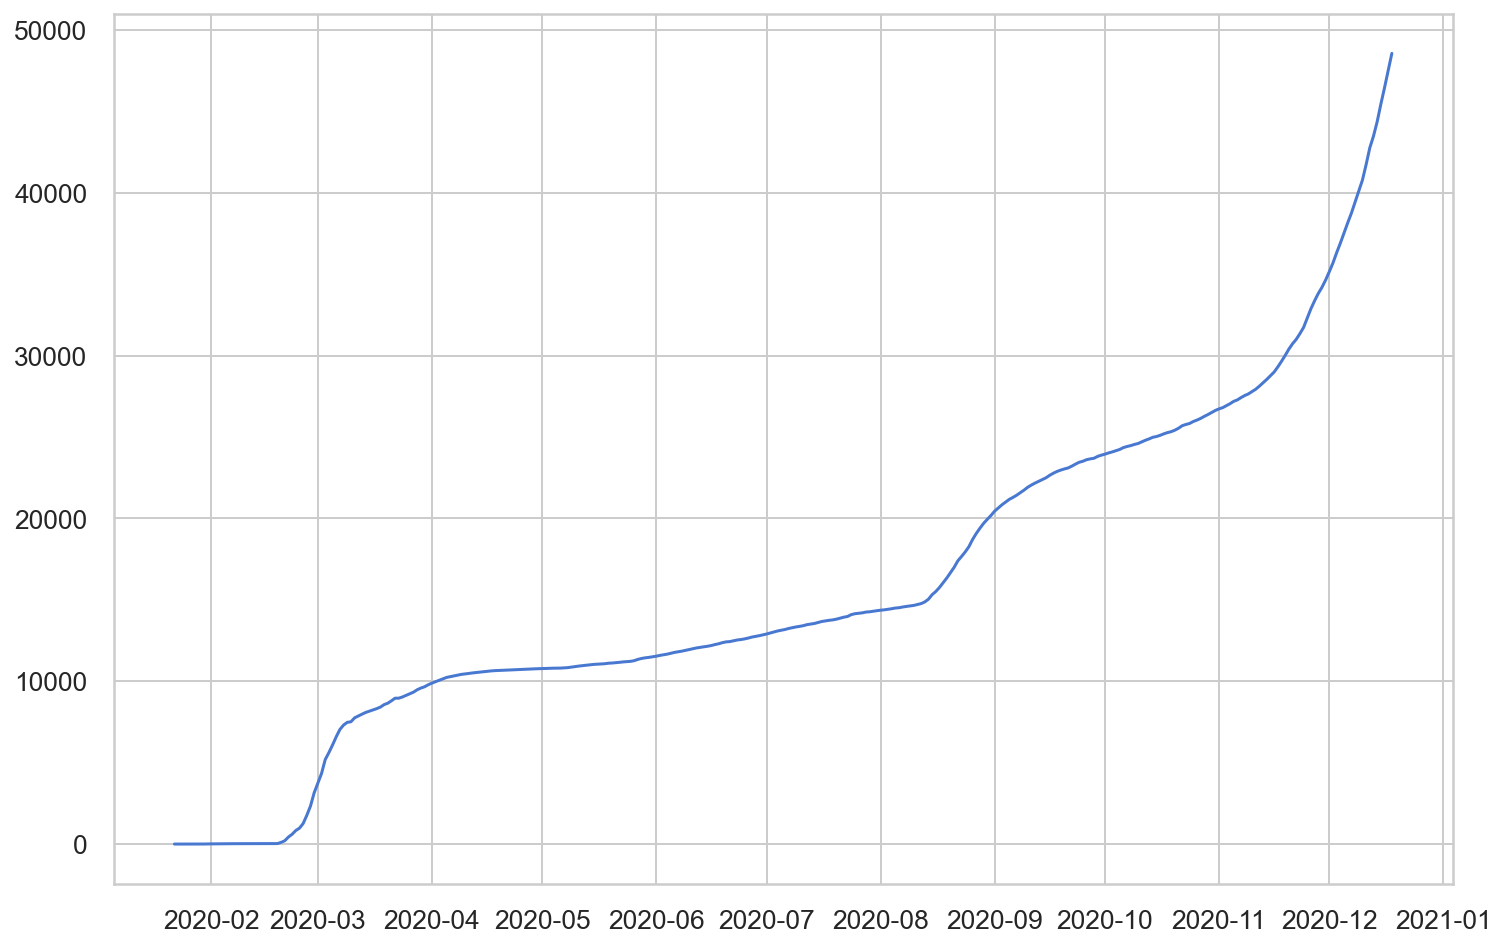

In [66]:
korea = confirmed[confirmed['Country/Region']=='Korea, South'].iloc[:,4:].T
korea.index = pd.to_datetime(korea.index)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

plt.plot(korea)
plt.show()

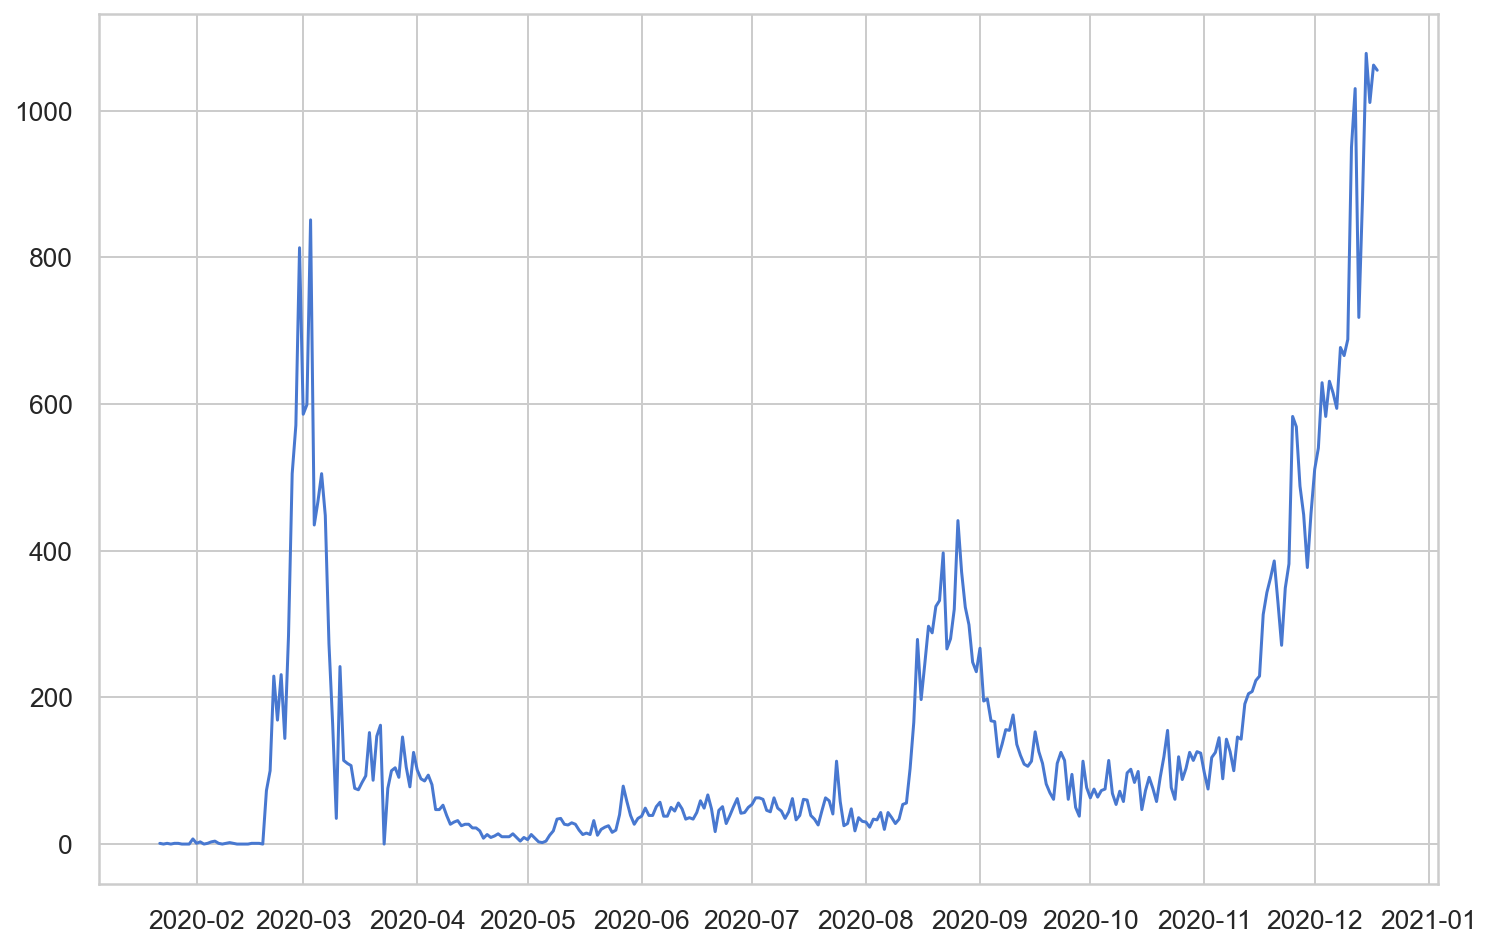

In [65]:
daily_cases = korea.diff().fillna(korea.iloc[0]).astype('int')
plt.plot(daily_cases)
plt.show()

In [76]:

def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length)]
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

#지도학습용 데이터로 변환
seq_length = 5
X, y = create_sequences(daily_cases, seq_length)

#학습용, 검증용, 시험용으로 분리
train_size = int(327 * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+33], y[train_size:train_size+33]
X_test, y_test = X[train_size+33:], y[train_size+33:]

MIN = X_train.min()
MAX = X_train.max()

def MinMaxScale(array, min, max):

    return (array - min) / (max - min)

#MinMax 스케일링
X_train = MinMaxScale(X_train, MIN, MAX)
y_train = MinMaxScale(y_train, MIN, MAX)
X_val = MinMaxScale(X_val, MIN, MAX)
y_val = MinMaxScale(y_val, MIN, MAX)
X_test = MinMaxScale(X_test, MIN, MAX)
y_test = MinMaxScale(y_test, MIN, MAX)

#Tensor 형태로 변환
def make_Tensor(array):
    return torch.from_numpy(array).float()

X_train = make_Tensor(X_train)
y_train = make_Tensor(y_train)
X_val = make_Tensor(X_val)
y_val = make_Tensor(y_val)
X_test = make_Tensor(X_test)
y_test = make_Tensor(y_test)

In [77]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

torch.Size([261, 5, 1]) torch.Size([33, 5, 1]) torch.Size([33, 5, 1])
torch.Size([261, 1]) torch.Size([33, 1]) torch.Size([33, 1])


# LSTM Model

In [79]:
class CovidPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(CovidPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [71]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
    loss_fn = torch.nn.L1Loss() #
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data): 

            model.reset_hidden_state() # seq 별 hidden state reset

            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:

            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() # seq 별로 hidden state 초기화 

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss
                
            val_hist.append(val_loss / len(val_data)) # val hist에 추가

            ## verbose 번째 마다 loss 출력 
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## patience 번째 마다 early stopping 여부 확인
            if (t % patience == 0) & (t != 0):
                
                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

            
    return model, train_hist, val_hist

0 851


In [72]:
def MinMaxScale(array, min, max):
    return (array - min) / (max - min)

In [73]:
X_train = MinMaxScale(X_train, MIN, MAX)
y_train = MinMaxScale(y_train, MIN, MAX)
X_val = MinMaxScale(X_val, MIN, MAX)
y_val = MinMaxScale(y_val, MIN, MAX)
X_test = MinMaxScale(X_test, MIN, MAX)
y_test = MinMaxScale(y_test, MIN, MAX)

In [74]:
import torch

def make_Tensor(array):
    return torch.from_numpy(array).float()

In [75]:
X_train = make_Tensor(X_train)
y_train = make_Tensor(y_train)
X_val = make_Tensor(X_val)
y_val = make_Tensor(y_val)
X_test = make_Tensor(X_test)
y_test = make_Tensor(y_test)